In [30]:
!pip install alpaca-py
!pip install matplotlib
!pip install ta


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29497 sha256=d884c9459ed77c282d7363d3f07b0ddb54e6cf6b03cd4566e958ebd620af8e2c
  Stored in directory: c:\users\aolivest\appdata\local\pip\cache\wheels\5c\a1\5f\c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [72]:
from alpaca.data import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime
import pandas as pd
import os

# Keys
API_KEY = os.getenv("ALPACA_API_KEY")
SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")

# no keys required for crypto data
stock_client = StockHistoricalDataClient(API_KEY,  SECRET_KEY)

stock = "MSFT"

request_params = StockBarsRequest(symbol_or_symbols=[stock], timeframe=TimeFrame.Minute, start=datetime(2025, 3, 11), end=datetime(2025, 3, 14))

bars = stock_client.get_stock_bars(request_params)

# Flatten the dictionary into a DataFrame
df = pd.DataFrame(bars[stock])

# Extrahera endast värdena från tuple-paren
df = df.map(lambda x: x[1])  # Tar bara det andra elementet i tuple:n

# Sätt kolumnnamn
df.columns = ["symbol", "timestamp", "open", "high", "low", "close", "volume", "trade_count", "vwap"]

In [73]:
import ta

df_indicators = df.copy()

# Beräkna EMA (Exponential Moving Average) med 9 och 21 perioder
df_indicators["EMA_short"] = ta.trend.ema_indicator(df_indicators["close"], window=9)
df_indicators["EMA_long"] = ta.trend.ema_indicator(df_indicators["close"], window=21)

# Beräkna MACD
df_indicators["MACD"] = ta.trend.macd(df_indicators["close"])
df_indicators["Signal_Line"] = ta.trend.macd_signal(df_indicators["close"])

# Beräkna ADX (Average Directional Index) för att mäta trendstyrka
df_indicators["ADX"] = ta.trend.adx(df_indicators["high"], df_indicators["low"], df_indicators["close"], window=14)

adx_threshold = 20  # Tröskel för trendstyrka

# Köp-signal (EMA crossover + MACD + ADX)
df_indicators.loc[(df_indicators["EMA_short"] > df_indicators["EMA_long"]) & (df_indicators["MACD"] > df_indicators["Signal_Line"]) & ((df_indicators["MACD"] - df_indicators["Signal_Line"]) > 0.1) & (df_indicators["ADX"] > adx_threshold),"Signal"] = 1  

# Sälj-signal (EMA crossover + MACD + ADX)
df_indicators.loc[(df_indicators["EMA_short"] < df_indicators["EMA_long"]) &  (df_indicators["MACD"] < df_indicators["Signal_Line"]) & ((df_indicators["Signal_Line"] - df_indicators["MACD"]) > 0.1) & (df_indicators["ADX"] > adx_threshold), "Signal"] = -1  

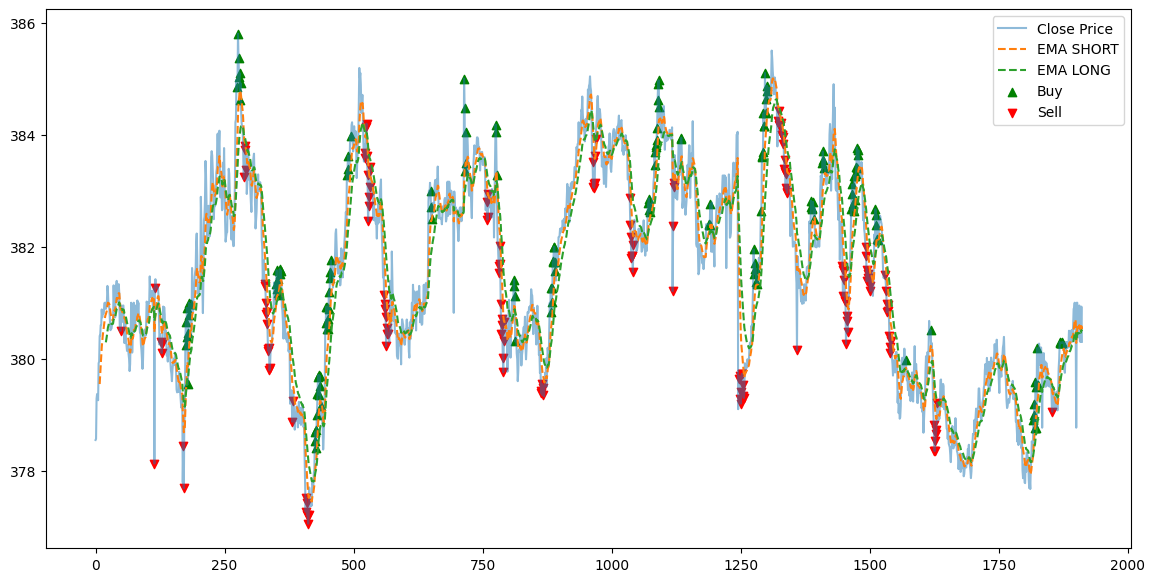

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(df_indicators["close"], label="Close Price", alpha=0.5)
plt.plot(df_indicators["EMA_short"], label="EMA SHORT", linestyle="dashed")
plt.plot(df_indicators["EMA_long"], label="EMA LONG", linestyle="dashed")

# Plotta köp och sälj-signaler
plt.scatter(df_indicators.index[df_indicators["Signal"] == 1], df_indicators["close"][df_indicators["Signal"] == 1], marker="^", color="g", label="Buy", alpha=1)
plt.scatter(df_indicators.index[df_indicators["Signal"] == -1], df_indicators["close"][df_indicators["Signal"] == -1], marker="v", color="r", label="Sell", alpha=1)

plt.legend()
plt.show()


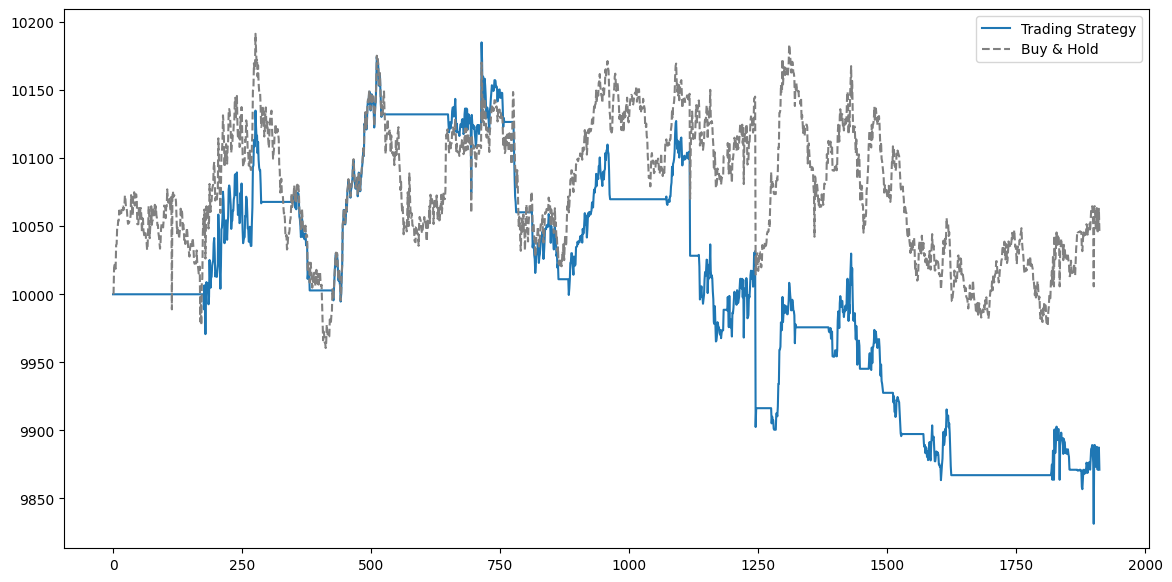

In [75]:
initial_capital = 10000  # Startkapital
position = 0  # 1 = Inne i en trade, 0 = Utanför
capital = initial_capital
returns = []
buy_and_hold_position = initial_capital / df_indicators["close"].iloc[0]
buy_and_hold = []

for i in range(len(df_indicators)):
    if df_indicators["Signal"].iloc[i] == 1 and position == 0:  # Köp
        position = capital / df_indicators["close"].iloc[i]  # Antal aktier
        capital = 0  # Vi har investerat allt
    elif df_indicators["Signal"].iloc[i] == -1 and position > 0:  # Sälj
        capital = position * df_indicators["close"].iloc[i]  # Sälj allt
        position = 0  # Vi har sålt
    returns.append(capital + (position * df_indicators["close"].iloc[i]))  # Värde av position
    buy_and_hold.append(buy_and_hold_position * df_indicators["close"].iloc[i])

df_indicators["Strategy Equity"] = returns
df_indicators["Buy & Hold Equity"] = buy_and_hold

# Plotta equity curve
plt.figure(figsize=(14, 7))
plt.plot(df_indicators["Strategy Equity"], label="Trading Strategy")
plt.plot(df_indicators["Buy & Hold Equity"], linestyle="dashed", color="gray", label="Buy & Hold")
plt.legend()
plt.show()